# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

from utils.resnet import ResNet

print(tf.__version__)

2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Read dataset 

In [3]:
dataDir = '/data/datasets/cifar100/raw'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'models/cifar100_resnet50_adam_v3'
logsDir = 'logs/cifar100_resnet50_adam_v3'

In [4]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 100
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [5]:
if not os.path.exists(configDir):
  os.makedirs(configDir)

if not os.path.exists(resultsDir):
  os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
  os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
  os.makedirs(logsDir)

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [8]:
meta = unpickle(os.path.join(dataDir, 'meta'))
train = unpickle(os.path.join(dataDir, 'train'))
test = unpickle(os.path.join(dataDir, 'test'))

In [9]:
classDF = pd.DataFrame(meta[b'fine_label_names'], columns = ['Classes'], dtype=str)
CLASS_NAMES = np.array(classDF['Classes'])

In [10]:
trainX = np.vstack(train[b"data"])
trainX = trainX.reshape(len(trainX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
trainY = np.array(train[b'fine_labels'])
trainY = tf.one_hot(trainY, NUM_CLASSES)

testX = np.vstack(test[b"data"])
testX = testX.reshape(len(testX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
testY = np.array(test[b'fine_labels'])#.reshape(-1,1)
testY = tf.one_hot(testY, NUM_CLASSES)

In [11]:
print(trainX.shape)
print(testX.shape)

print(trainY.shape)
print(testY.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 100)
(10000, 100)


In [12]:
aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=18, zoom_range=0.15,
                                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                                                   horizontal_flip=True, fill_mode="nearest")

## Create model

In [13]:
modelDiagramFile = os.path.join(resultsDir, 'model_resnet50_cifar100.png')

model = ResNet.build(32, 32, NUM_CHANNELS, NUM_CLASSES, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)

#keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)

## Train model

In [14]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    print('Learning rate: ', lr)
    return lr

In [15]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logsCheckDir + "/metrics")
file_writer.set_as_default()

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)
ck_callback = keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5"))
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks = [tb_callback, ck_callback, lr_callback]

optimizer = tf.optimizers.Adam(learning_rate=lr_schedule(0))

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Learning rate:  0.001


In [16]:
startTime = time.time()

model.fit(x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
          validation_data=(testX, testY),
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Learning rate:  0.001
Epoch 1/200
391/391 [==============================] - 42s 107ms/step - loss: 4.3990 - accuracy: 0.0993 - val_loss: 4.1426 - val_accuracy: 0.1343 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - 40s 101ms/step - loss: 3.8734 - accuracy: 0.1762 - val_loss: 3.6340 - val_accuracy: 0.2180 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - 40s 102ms/step - loss: 3.5152 - accuracy: 0.2366 - val_loss: 3.3198 - val_accuracy: 0.2719 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - 40s 102ms/step - loss: 3.2397 - accuracy: 0.2891 - val_loss: 3.0661 - val_accuracy: 0.3228 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
391/391 [==============================] - 40s 102ms/step - loss: 3.0097 - accuracy: 0.3360 - val_loss: 3.0721 - val_accuracy: 0.3430 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
391/391 [==============================] - 40s 102ms/step - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 39s 101ms/step - loss: 0.8501 - accuracy: 0.8976 - val_loss: 1.7346 - val_accuracy: 0.7068 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 98/200
391/391 [==============================] - 39s 100ms/step - loss: 0.8465 - accuracy: 0.8964 - val_loss: 1.7429 - val_accuracy: 0.7038 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 99/200
391/391 [==============================] - 39s 101ms/step - loss: 0.8416 - accuracy: 0.8984 - val_loss: 1.7428 - val_accuracy: 0.7018 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 100/200
391/391 [==============================] - 39s 100ms/step - loss: 0.8295 - accuracy: 0.9014 - val_loss: 1.7347 - val_accuracy: 0.7062 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 101/200
391/391 [==============================] - 39s 100ms/step - loss: 0.8233 - accuracy: 0.9011 - val_loss: 1.7543 - val_accuracy: 0.7037 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 102/200
391/391 [==============================] - 39s 100ms/step - lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 39s 100ms/step - loss: 0.7177 - accuracy: 0.9220 - val_loss: 1.7992 - val_accuracy: 0.6968 - lr: 1.0000e-04
Learning rate:  1e-05
Epoch 122/200
391/391 [==============================] - 39s 101ms/step - loss: 0.7011 - accuracy: 0.9279 - val_loss: 1.7756 - val_accuracy: 0.7003 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 123/200
391/391 [==============================] - 39s 101ms/step - loss: 0.6920 - accuracy: 0.9304 - val_loss: 1.7572 - val_accuracy: 0.7049 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 124/200
391/391 [==============================] - 40s 101ms/step - loss: 0.6858 - accuracy: 0.9319 - val_loss: 1.7681 - val_accuracy: 0.7029 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 125/200
391/391 [==============================] - 39s 100ms/step - loss: 0.6848 - accuracy: 0.9329 - val_loss: 1.7609 - val_accuracy: 0.7031 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 126/200
391/391 [==============================] - 39s 101ms/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 39s 100ms/step - loss: 0.6648 - accuracy: 0.9372 - val_loss: 1.7648 - val_accuracy: 0.7075 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 145/200
391/391 [==============================] - 39s 100ms/step - loss: 0.6657 - accuracy: 0.9370 - val_loss: 1.7585 - val_accuracy: 0.7060 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 146/200
391/391 [==============================] - 39s 100ms/step - loss: 0.6623 - accuracy: 0.9393 - val_loss: 1.7744 - val_accuracy: 0.7027 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 147/200
391/391 [==============================] - 39s 100ms/step - loss: 0.6623 - accuracy: 0.9388 - val_loss: 1.7780 - val_accuracy: 0.7065 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 148/200
391/391 [==============================] - 39s 101ms/step - loss: 0.6598 - accuracy: 0.9395 - val_loss: 1.7699 - val_accuracy: 0.7049 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 149/200
391/391 [==============================] - 39s 100ms/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 39s 101ms/step - loss: 0.6537 - accuracy: 0.9402 - val_loss: 1.7971 - val_accuracy: 0.7029 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 167/200
391/391 [==============================] - 39s 101ms/step - loss: 0.6502 - accuracy: 0.9415 - val_loss: 1.7893 - val_accuracy: 0.7042 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 168/200
391/391 [==============================] - 39s 100ms/step - loss: 0.6510 - accuracy: 0.9407 - val_loss: 1.7937 - val_accuracy: 0.7015 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 169/200
391/391 [==============================] - 39s 101ms/step - loss: 0.6543 - accuracy: 0.9405 - val_loss: 1.7693 - val_accuracy: 0.7037 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 170/200
391/391 [==============================] - 39s 101ms/step - loss: 0.6520 - accuracy: 0.9408 - val_loss: 1.7858 - val_accuracy: 0.7018 - lr: 1.0000e-06
Learning rate:  1e-06
Epoch 171/200
391/391 [==============================] - 39s 101ms/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Save model

In [17]:
modelFile = os.path.join(modelsDir, 'model_resnet50.h5')

model.save(modelFile)

## Plot confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [20]:
y_pred=np.argmax(model.predict(testX), axis=1)
y_true=np.argmax(testY, axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


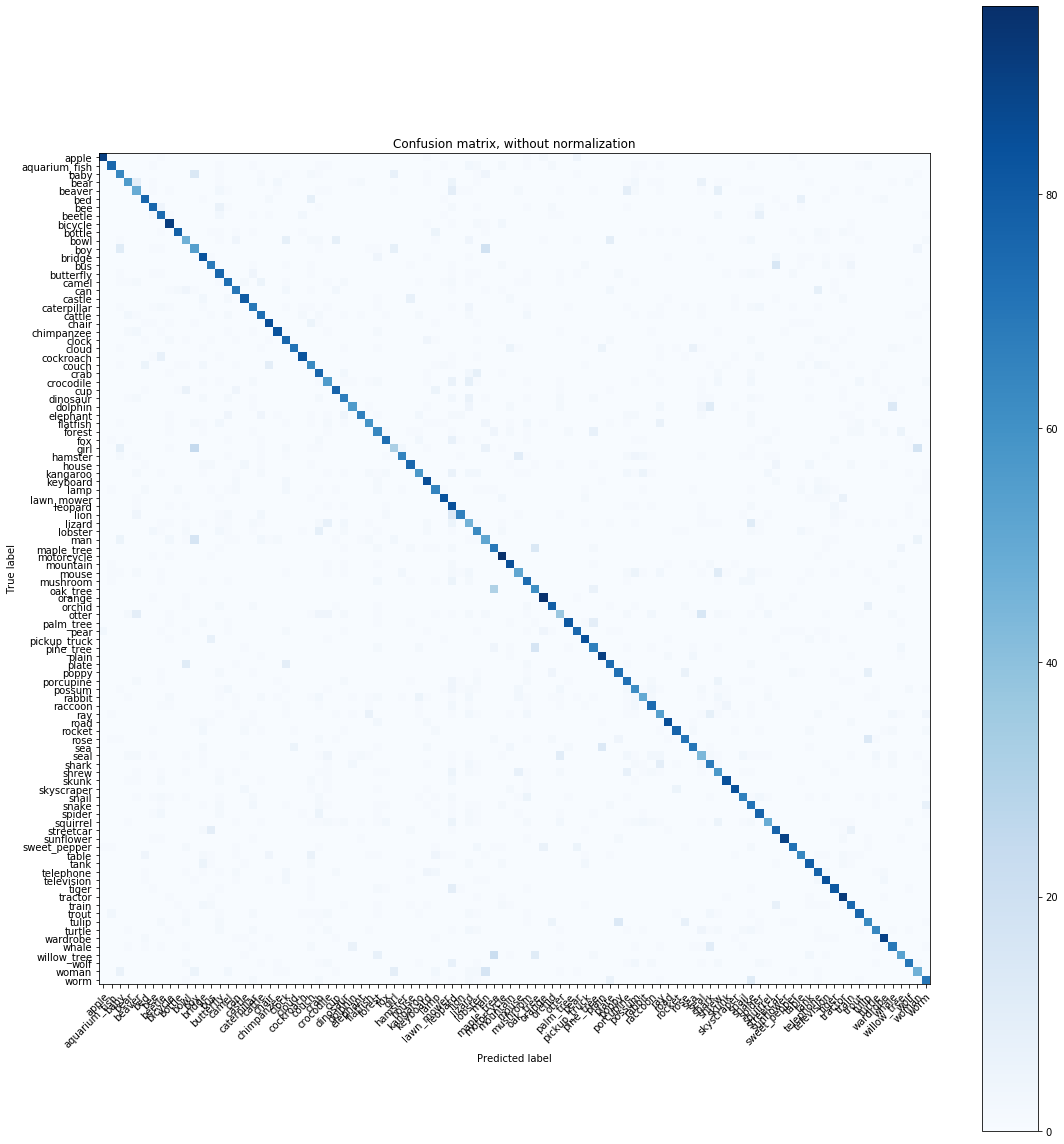

In [21]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=CLASS_NAMES,
                      title='Confusion matrix, without normalization')